In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.cosmology
import scipy.stats
import time
from useful_funcs import PAUSflux_to_ABmag
import h5py
import matplotlib.colors
import os
from SAVEFIG import main as custom_SAVEFIG

latex_textwidth = 455.24#pt

def fixed_aspect_ratio(ratio):
    '''
    Set a fixed aspect ratio on matplotlib plots 
    regardless of axis units
    '''
    xvals,yvals = plt.gca().axes.get_xlim(),plt.gca().axes.get_ylim()

    xrange = xvals[1]-xvals[0]
    yrange = yvals[1]-yvals[0]
    plt.gca().set_aspect(ratio*(xrange/yrange), adjustable='box')

#matplotlib.rcParams['agg.path.chunksize'] = 10000

In [2]:
from astropy.cosmology import Planck15 as cosmo

cosmo = cosmo.clone(name='Planck15 H0 = 100', H0=100) #setting H0 = 100 km/s/MPc, h = 1


In [3]:
data = pd.read_pickle("../../Data/Object_zs_zp_181203_130401.pkl.gz")


lcCoreFilename = "Gonzalez13.PAU.MillGas.field1.core.0.hdf5"
lcPhotomFilename = "Gonzalez13.PAU.MillGas.field1.photometry.0.hdf5"

if os.environ['NAME'] == 'DESKTOP-RB5C8OC': 
    file_path = '/mnt/e/L4ProjectLocal/LightConeData/'
elif os.environ['NAME'] == 'LaNaranjaDos':
    file_path = '/mnt/c/Users/Andrew/L4ProjectLocal/Light Cone Data/'
else: raise Exception('Device not configured for hdf5 data load')

LC_DATA_CORE = h5py.File(file_path+lcCoreFilename, "r")
LC_DATA_PHOTOM = h5py.File(file_path+lcPhotomFilename, "r")

In [4]:
data['production_id'].unique()

array([866])

[         nan 386.85524126 395.17470882 ... 660.         668.
 676.        ]
[351.35135135 359.07335907 366.7953668  ... 594.38040346 601.58501441
 608.78962536]
[         nan          nan 314.77799867 ... 573.31480195 580.26407227
 587.2133426 ]
[286.70447385 293.00567108 299.3068683  ... 521.16234997 527.47946936
 533.79658876]
[246.34542501 251.75961018 257.17379534 ... 472.50859107 478.23596793
 483.96334479]
[230.84728564 235.92085236 240.99441908 ... 427.01863354 432.19461698
 437.37060041]
[219.06596052 223.88059701 228.69523351 ... 385.69424965 390.36933146
 395.04441328]
[211.43122677 216.07806691 220.72490706 ... 375.         379.54545455
 384.09090909]


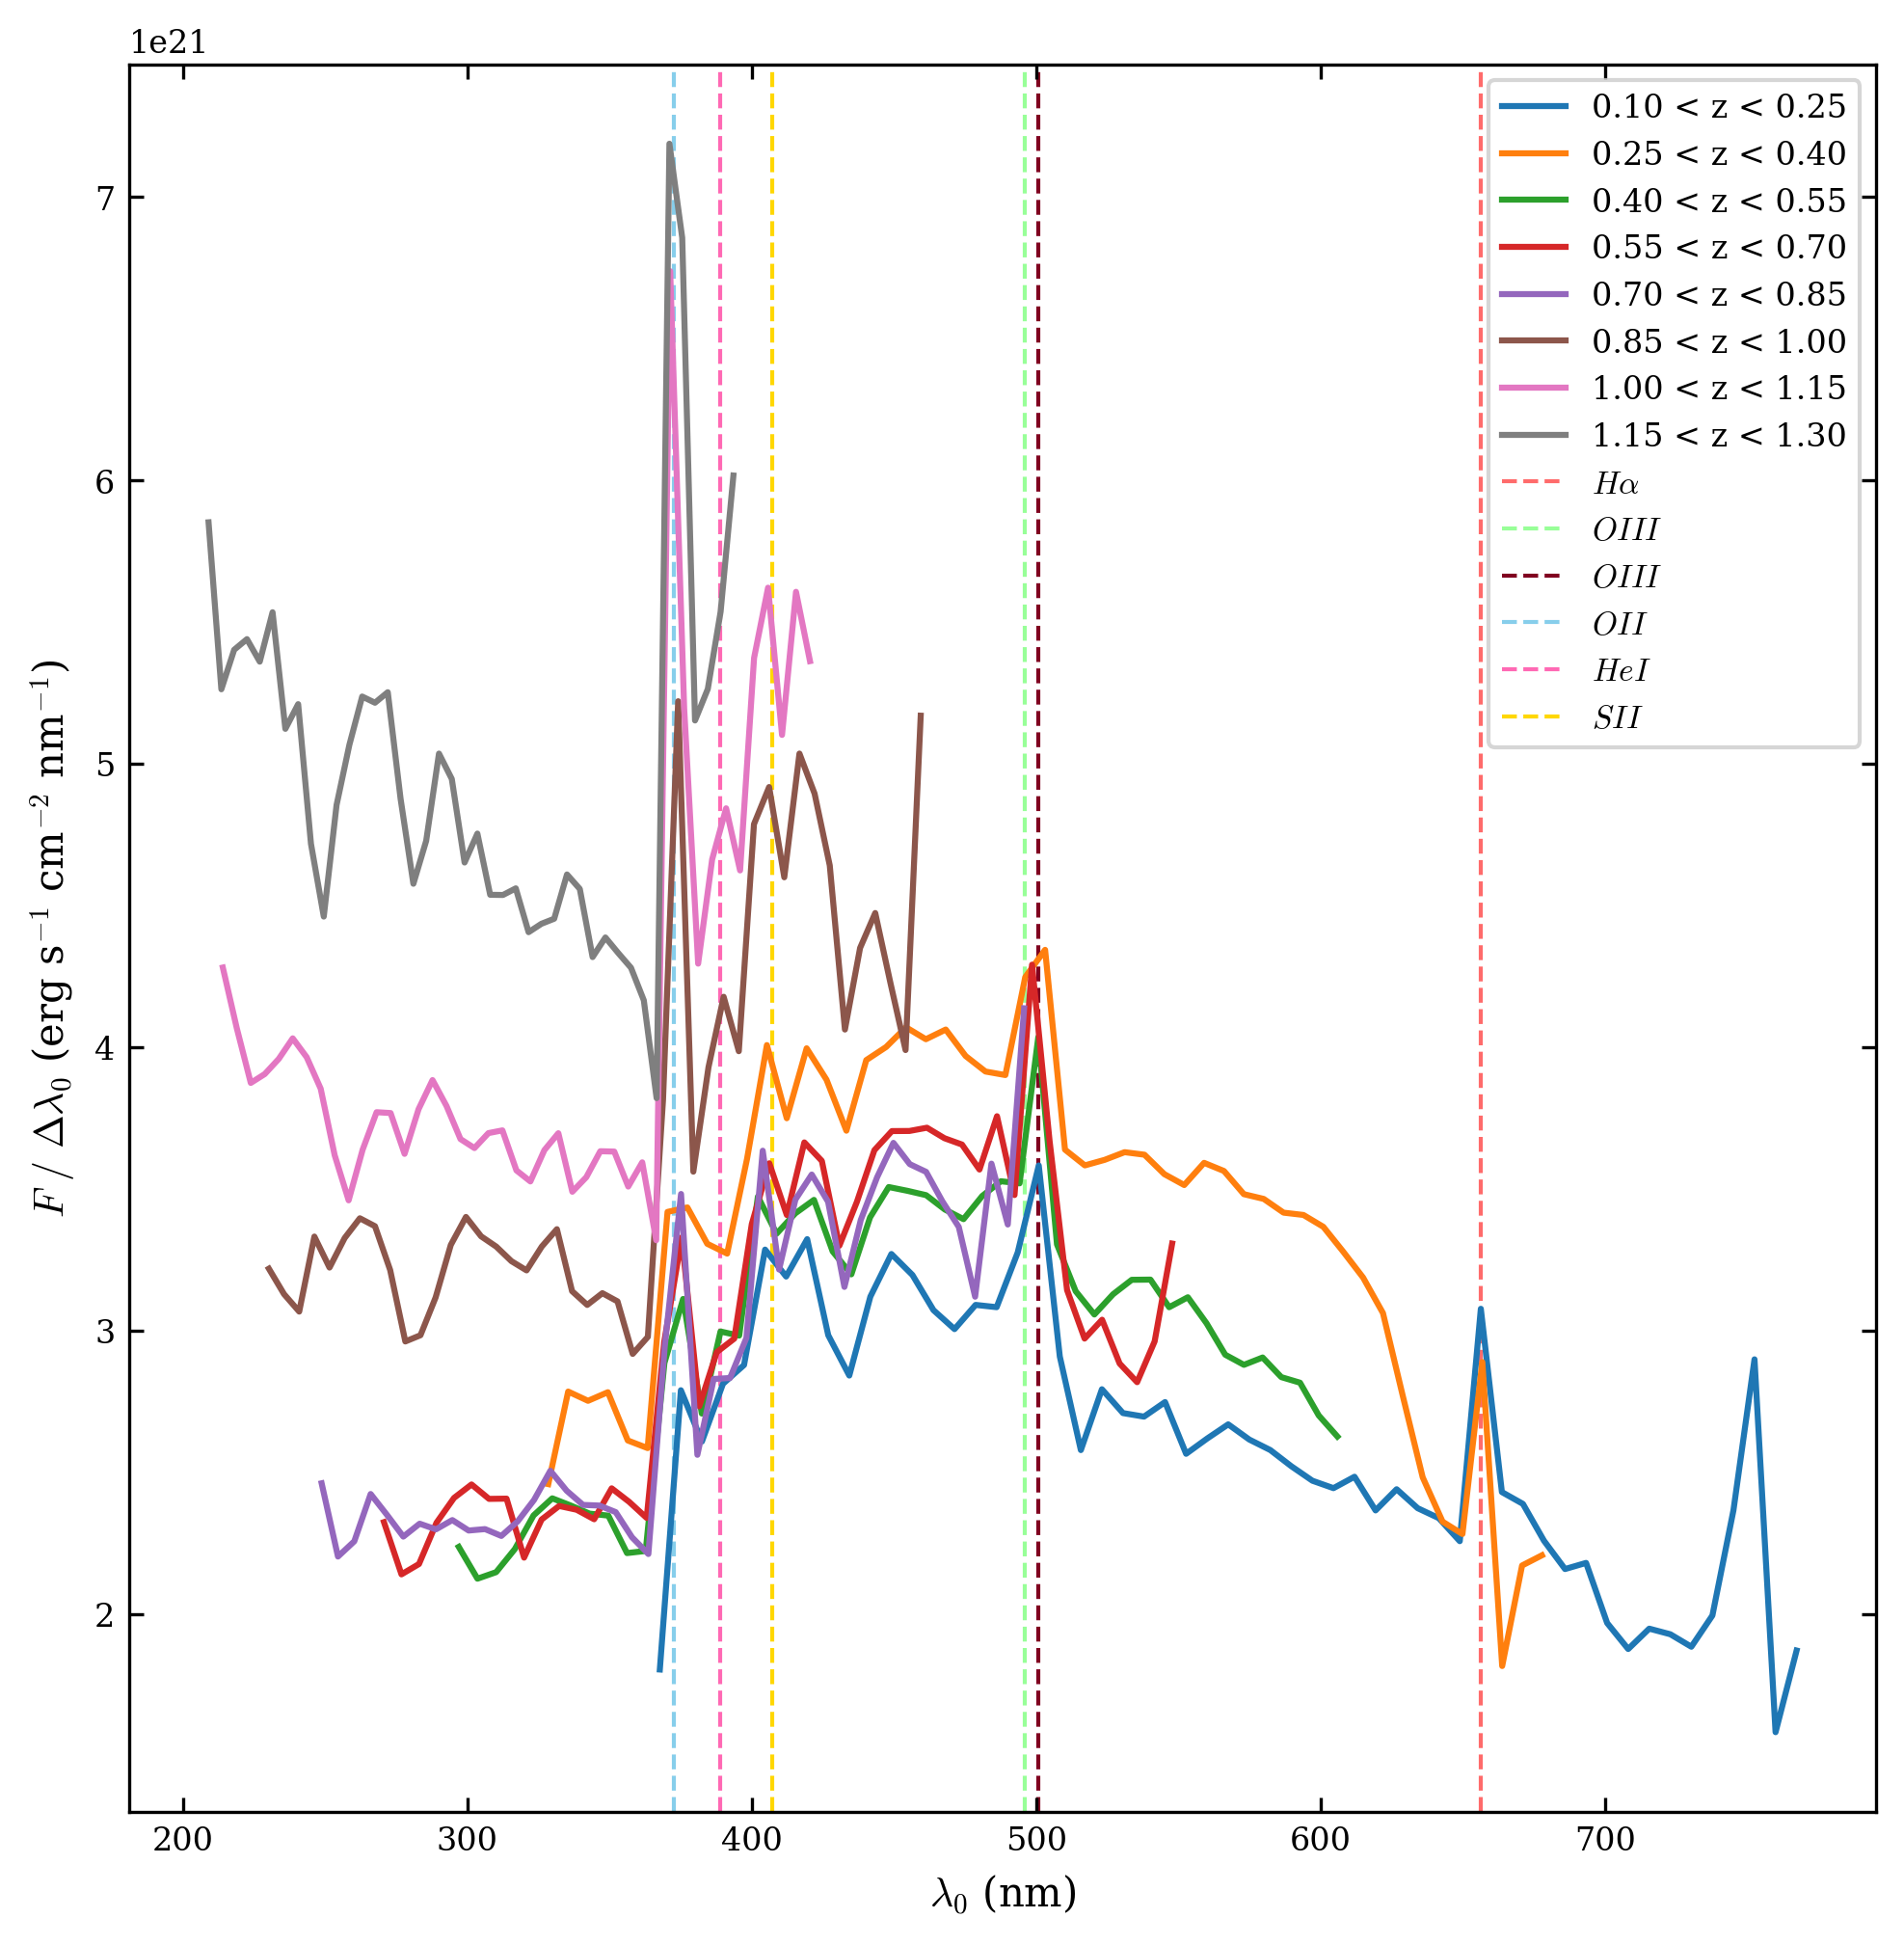

In [13]:
mask = data['conf'].astype('str').str.match('^[34]\.[0-9]$') | data['conf'].astype('str').str.match('^[29]\.5$') 
data_sample = data.loc[(data['n_bands']>=30)]# & mask & (data['zspec']!=0)]

lum_dists_1d = cosmo.luminosity_distance(data_sample['zb']).value
luminosity_distances = np.repeat(lum_dists_1d[:,None],40,axis=1)
z_photos = data_sample['zb']




################################# PLOT 1 #################################



# bins = [[0.1,0.27],[0.2,0.38],[0.3,0.5],[0.4,0.61],[0.5,0.72],[0.6,0.84],[0.7,0.96],[0.8,1.07],[0.9,1.19],[1,1.3],[1.1,1.42]]
bins = []
bin_range = [0.1,1.2]
bin_increment = 0.15
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]]) 

factor = 1/8.5 * latex_textwidth/72

fig = plt.figure(figsize=(8,8),dpi=300)
# ax1 = plt.subplot(121)

band_obsframe = data_sample.loc[:,'band0':'band39'].values/(data_sample['zb'].values[:,None]+1)
# print(data_sample.loc[:,'band0':'band39'])

increments = np.linspace(90,150,len(bins))

all_means = []
bandwidtharray = np.linspace(7.4,4.5,len(bins))


for ind,z_bin in enumerate(bins):
#     band_bins,step = np.linspace(200,860,increments[ind],retstep=True)
#     print("wl bin step = {:3.2f}".format(step))

    truth_table = (z_photos >= z_bin[0]) & (z_photos <= z_bin[1])
    lamb_sample = band_obsframe[truth_table].flatten()
    flux_sample = data_sample.loc[truth_table,'band0_flux':'band39_flux'].values.flatten()
    z_samp = np.repeat(z_photos[truth_table],40)
#     print(z_samp)
#     print(z_samp.size,flux_sample.size,z_photos.size)
    lum_dist_sample = luminosity_distances[truth_table].flatten()
    
    band_width = bandwidtharray[ind]
#     print(lamb_sample.min(),lamb_sample.max())
    band_bins = np.arange(np.nanmin(lamb_sample),np.nanmax(lamb_sample)+band_width,band_width)
    
#     flux_sample = 10**((26-flux_sample)/2.5) #<---- AB mag to flux conversion
    
    N_objects = band_obsframe[truth_table].shape[0]
    
    digitized = np.digitize(lamb_sample,band_bins)
    #Pre- broken
#     binned_means = [np.nanmedian(flux_sample[digitized == i]) for i in range(1,len(band_bins))]
#     all_means.append(binned_means/(band_bins[1:]+band_bins[:-1])*2) #flux(in AB mags)/band wl
#     plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means)/(band_bins[1:]+band_bins[:-1])*2,\
#              label="{:.02f} < z < {:.02f}, N = {}".format(z_bin[0],z_bin[1],N_objects)) #flux(in AB mags)/500 band wl

    FWHM = 13

    #binned_means = [np.nanmedian(flux_sample[digitized == i]/FWHM*(1+z_samp[digitized == i])) for i in range(1,len(band_bins))]
    # ^ what has been used so far
    
    binned_means = [np.nanmedian(flux_sample[digitized == i]/FWHM*(1+z_samp[digitized == i])) for i in range(1,len(band_bins))]
    
    
    all_means.append(binned_means) #flux(in AB mags)/band wl
    plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means),\
             label="{:.02f} < z < {:.02f}".format(z_bin[0],z_bin[1]),zorder=10,linewidth=1.5) #flux(in AB mags)/500 band wl
    

                                 
        

# print(np.array(all_means))
# plt.plot((band_bins[1:]+band_bins[:-1])/2,np.nanmedian(np.array(all_means),axis=0),'k-',linewidth=3,label="Median SED")

emis_lines = [[656.28,r'$H\alpha$'],[496,r'$OIII$'],[500.8,r'$OIII$'],[372.8,r"$OII$"],[388.9,r'$HeI$'],[407.2,r'$SII$']]
colours = ['#ff6b6b','#98ff98','#800020','skyblue','hotpink','gold','black','white']
for i,line in enumerate(emis_lines):
#     random_ints = np.random.randint(256,size=3)
# color = #{}{}{}'.format(hex(random_ints[0])[2:].zfill(2),hex(random_ints[1])[2:].zfill(2),hex(random_ints[2])[2:].zfill(2))
    plt.axvline(line[0],color=colours[i],linestyle='--',zorder=1,label=line[1])

plt.xlabel(r'$\lambda_0$ (nm)')
plt.ylabel(r'$F\ /\ \Delta\lambda_0$ (erg s$^{-1}$ cm$^{-2}$ nm$^{-1}$)')
# plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1),ncol=2,frameon=False)
fixed_aspect_ratio(1)
# custom_SAVEFIG(filetag='SED_LD')

# plt.yscale('log')
# plt.ylim([0,2.5e6])
#plt.xlim([200,680])
# plt.show()



# fig.subplots_adjust(wspace=0.25)
# fig.subplots_adjust(bottom=0.3)
# ax1.yaxis.labelpad, ax2.yaxis.labelpad = 1,1

plt.legend()
# custom_SAVEFIG(filetag='SED_LD')
plt.show()



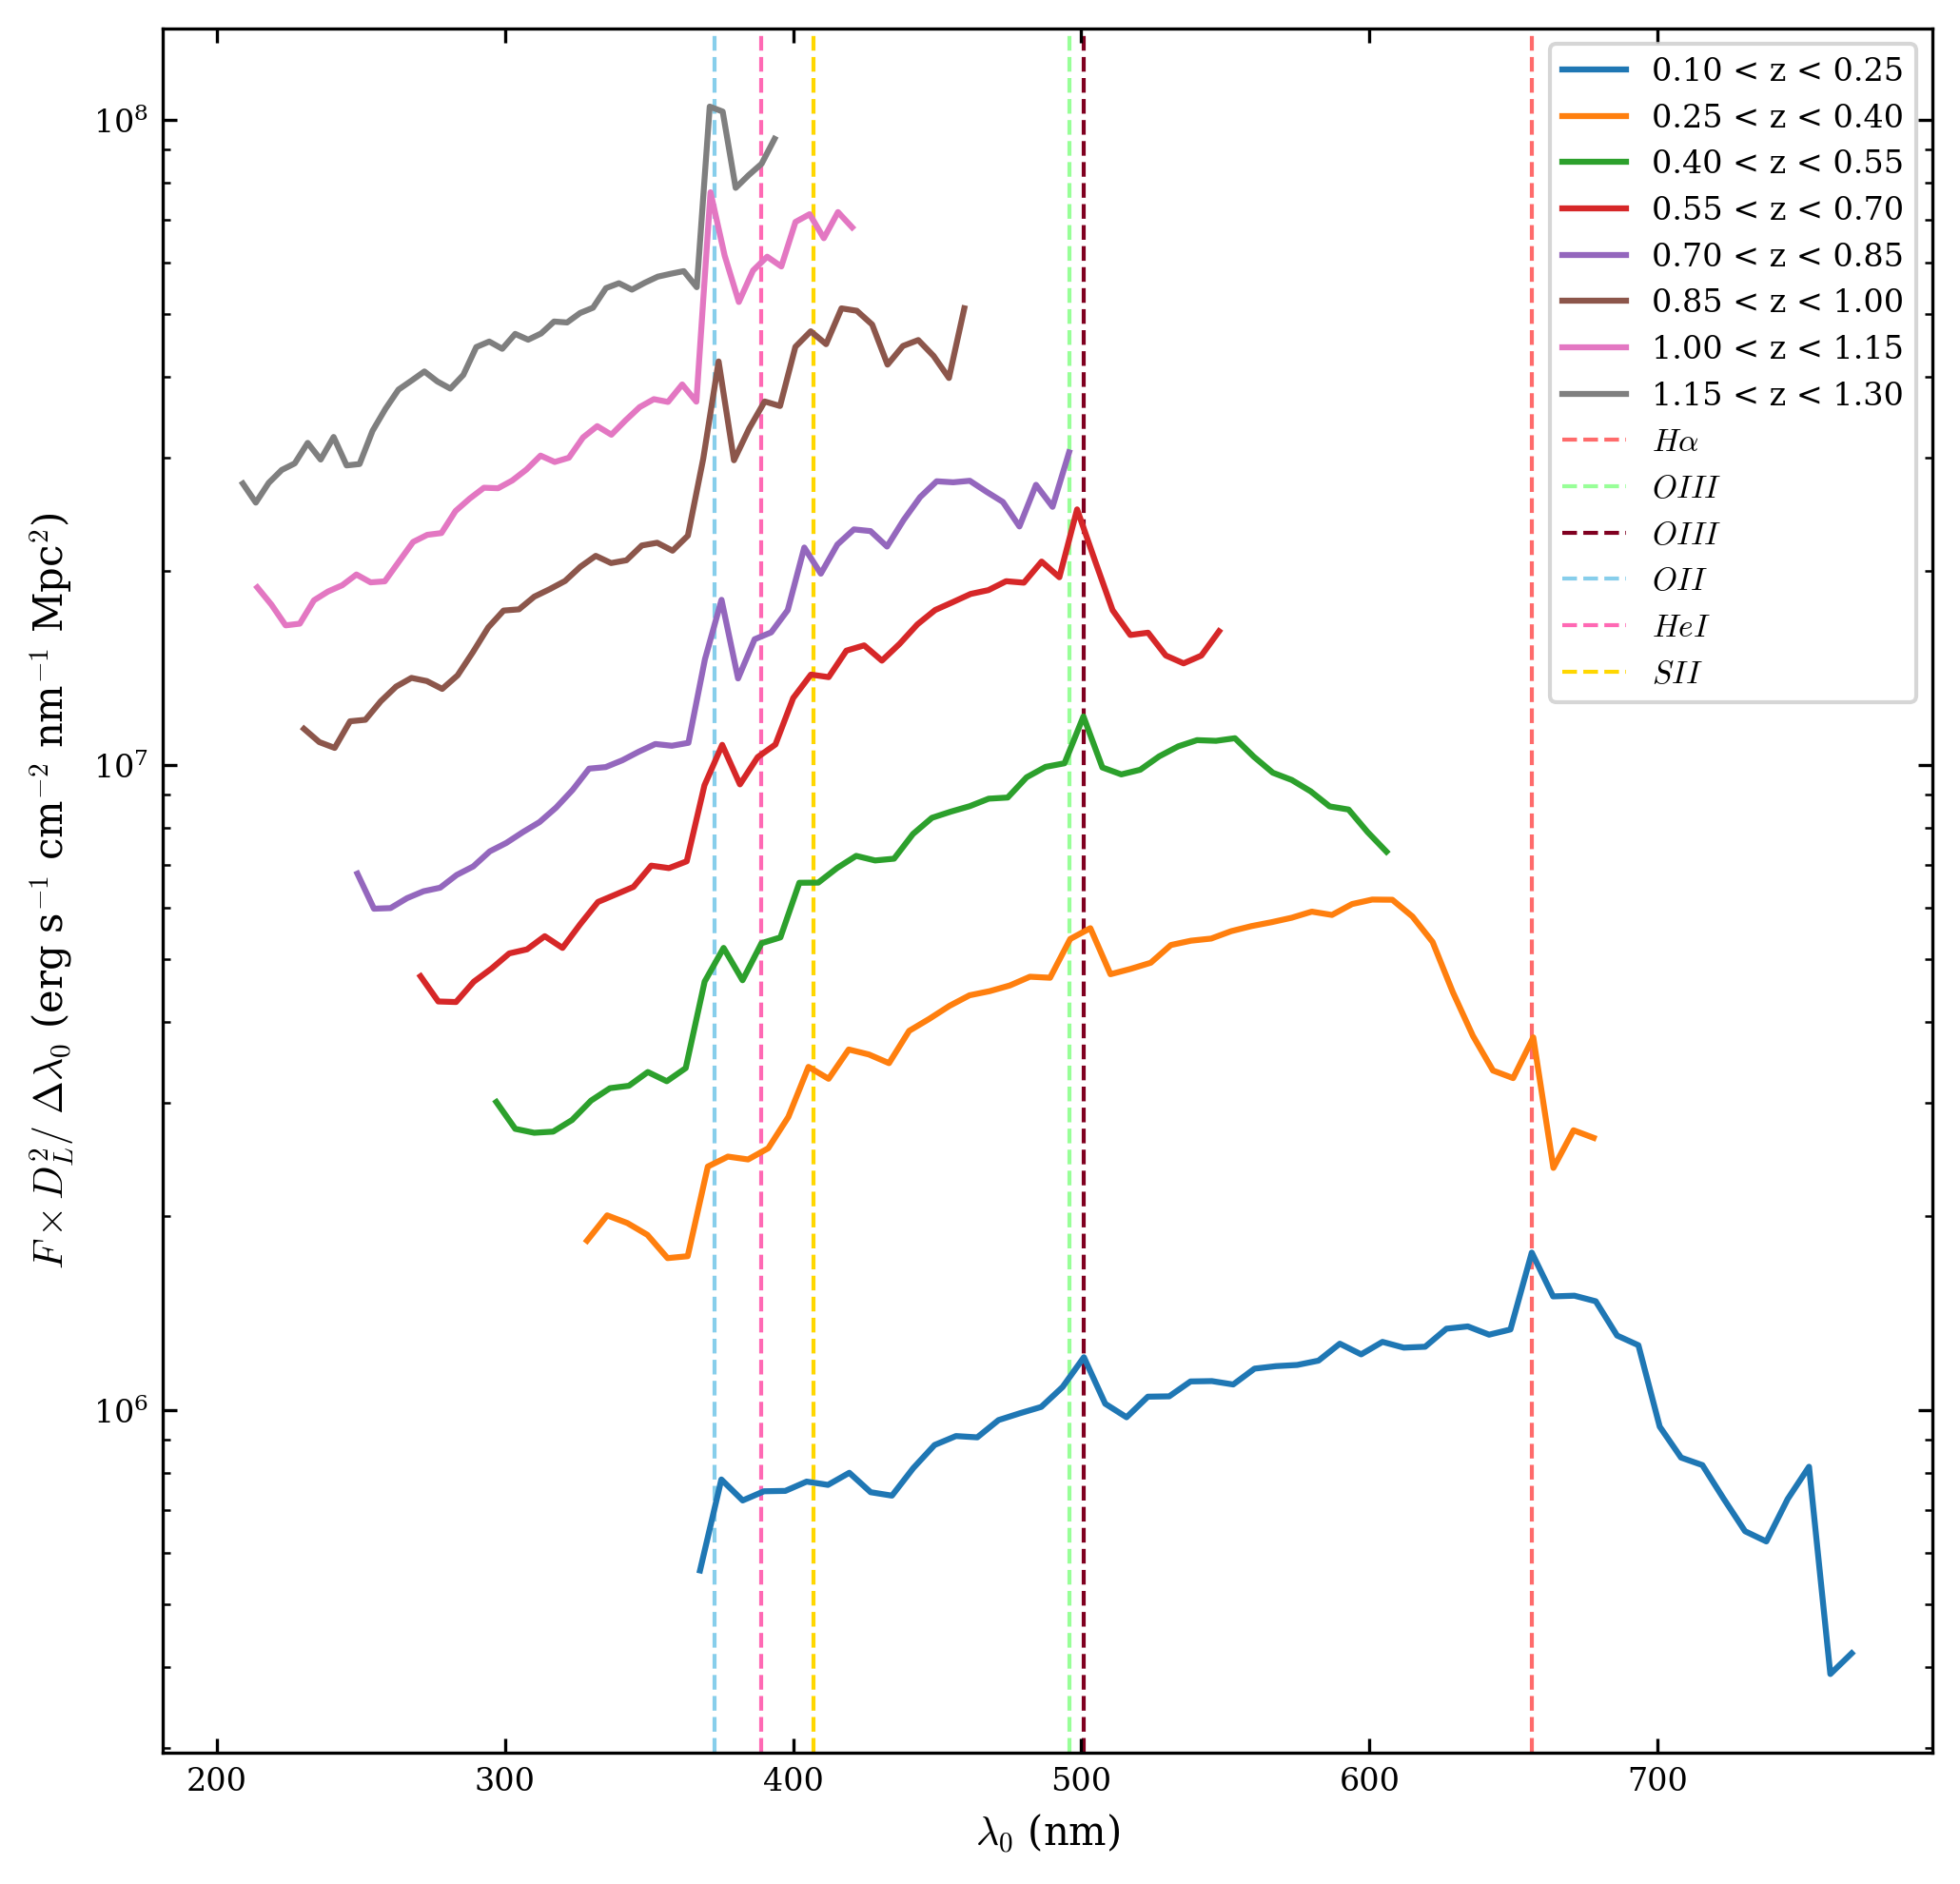

In [11]:


################################# PLOT 2 #################################
fig = plt.figure(figsize=(8,8),dpi=300)

bins = []
bin_range = [0.1,1.2]
bin_increment = 0.15
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]]) 

# bins = [[0.7,0.75],[0.75,0.8],[0.8,0.85]]
max_factor = 7.25
# factor = 1/max_factor*latex_textwidth/72
# fig = plt.figure(figsize=(7.5*factor,max_factor*factor),dpi=300)

band_obsframe = data_sample.loc[:,'band0':'band39'].values/(data_sample['zb'].values[:,None]+1)
# print(band_obsframe.min(),band_obsframe.max())

increments = np.linspace(90,150,len(bins))

# print(band_obsframe,band_bins)
all_means = []
# print(data.loc[(data['imag']==0)|(data['rmag']==0)|(data['odds']<0)]['flux'])
# band_bins = np.arange(200,860,band_bin_incs[ind])

for ind,z_bin in enumerate(bins):
#     band_bins,step = np.linspace(200,860,increments[ind],retstep=True)
#     print("wl bin step = {:3.2f}".format(step))
#     print(band_bins)
    truth_table = (z_photos >= z_bin[0]) & (z_photos <= z_bin[1])
    lamb_sample = band_obsframe[truth_table].flatten()
    flux_sample = data_sample.loc[truth_table,'band0_flux':'band39_flux'].values.flatten()
    lum_dist_sample = luminosity_distances[truth_table].flatten()
    z_samp = np.repeat(z_photos[truth_table],40)
    band_width = bandwidtharray[ind]
#     print(lamb_sample.min(),lamb_sample.max())
    band_bins = np.arange(np.nanmin(lamb_sample),np.nanmax(lamb_sample)+band_width,band_width)
#     print(lamb_sample.shape,flux_sample.shape,lum_dist_sample.shape)
    
#     flux_sample = 10**((26-flux_sample)/2.5) #<---- AB mag to flux conversion
    
    N_objects = band_obsframe[truth_table].shape[0]
    
    digitized = np.digitize(lamb_sample,band_bins)
# Pre-changed
#     binned_means = [np.nanmedian(flux_sample[digitized == i] * lum_dist_sample[digitized == i]**2) for i in range(1,len(band_bins))]
#     all_means.append(binned_means/(band_bins[1:]+band_bins[:-1])*2) #flux(in AB mags)/band wl
# #     print (binned_means)
    
#     plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means)/(band_bins[1:]+band_bins[:-1])*2,\
#              label="{:.02f} < z < {:.02f}, N = {}".format(z_bin[0],z_bin[1],N_objects)) #flux(in AB mags)/500 band wl
    
    FWHM = 13 #nm
    
    binned_means = [np.nanmedian(flux_sample[digitized == i]/FWHM*(1+z_samp[digitized == i])*lum_dist_sample[digitized == i]**2) for i in range(1,len(band_bins))]
    all_means.append(binned_means) #flux(in AB mags)/band wl
    plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means),\
             label="{:.02f} < z < {:.02f}".format(z_bin[0],z_bin[1]),zorder=10,linewidth=1.5) #flux(in AB mags)/500 band wl

# print(np.array(all_means))
# plt.plot((band_bins[1:]+band_bins[:-1])/2,np.nanmedian(np.array(all_means),axis=0),'k-',linewidth=3,label="Median SED")

emis_lines = [[656.28,r'$H\alpha$'],[496,r'$OIII$'],[500.8,r'$OIII$'],[372.8,r"$OII$"],[388.9,r'$HeI$'],[407.2,r'$SII$']]

for i,line in enumerate(emis_lines):
#     random_ints = np.random.randint(256,size=3)
# color = #{}{}{}'.format(hex(random_ints[0])[2:].zfill(2),hex(random_ints[1])[2:].zfill(2),hex(random_ints[2])[2:].zfill(2))
    plt.axvline(line[0],label=line[1],color=colours[i],linestyle='--',zorder=1)

plt.xlabel(r'$\lambda_0$ (nm)')
plt.ylabel(r'$F \times D_L^2 /\ \Delta\lambda_{0}$ (erg s$^{-1}$ cm$^{-2}$ nm$^{-1}$ Mpc$^2$)')
plt.legend()

# ax1.tick_params(labelbottom=False)

plt.yscale('log')
# plt.ylim([0,2.5e6])
#plt.xlim([200,680])
fixed_aspect_ratio(1)

plt.show()